In [1]:
from fastai.vision.all import *
from moving_mnist.models.phy_original import *
from moving_mnist.models.seq2seq import TeacherForcing
from moving_mnist.models.conv_rnn import StackUnstack, StackLoss, MultiImageDice
from moving_mnist.data import *

In [2]:
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    print(torch.cuda.get_device_name())
    device = 0

Quadro RTX 8000


# Train PhyDNet:

We wil predict:
- `n_in`: 5 images
- `n_out`: 5 images  
- `n_obj`: up to 3 objects

In [3]:
Path.cwd()

Path('/home/tcapelle/SteadySun/moving_mnist')

In [4]:
DATA_PATH = Path.cwd()/'data'

In [5]:
ds = MovingMNIST(DATA_PATH, n_in=5, n_out=5, n_obj=[1,2], th=None)

In [6]:
train_tl = TfmdLists(range(12500), ImageTupleTransform(ds))
valid_tl = TfmdLists(range(100), ImageTupleTransform(ds))

In [7]:
m,s = mnist_stats
print(m,s)
scale = 28**2/64**2
m = m[0]*2*scale
s = s[0]*4*scale

[0.131] [0.308]


In [8]:
m,s, scale

(0.050148437500000004, 0.2358125, 0.19140625)

In [9]:
dls = DataLoaders.from_dsets(train_tl, valid_tl, bs=64,#).cuda()
                             after_batch=[Normalize.from_stats(m,s)]).cuda()

In [10]:
mse_loss = StackLoss(MSELossFlat(axis=1))
metrics = []

Left: Input, Right: Target

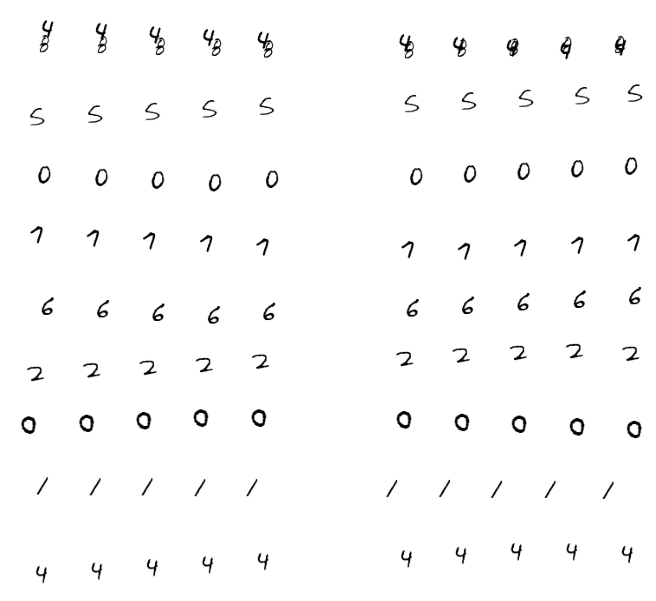

In [11]:
dls.show_batch()

In [12]:
b = dls.one_batch()

In [13]:
explode_types(b)

{tuple: [{moving_mnist.data.ImageSeq: [fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW]},
  {moving_mnist.data.ImageSeq: [fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW]}]}

In [14]:
x,y = b 
x[0].shape

torch.Size([64, 1, 64, 64])

In [15]:
x_s = torch.stack(x, axis=1)

In [16]:
x_s.shape

torch.Size([64, 5, 1, 64, 64])

In [17]:
x_s.min(), x_s.max(), x_s.mean()

(tensor(-0.2127, device='cuda:0'),
 tensor(4.0280, device='cuda:0'),
 tensor(-0.0475, device='cuda:0'))

In [18]:
y_s = torch.stack(y, axis=1)

In [19]:
y_s.min(), y_s.max(), y_s.mean(), y_s.std()

(tensor(-0.2127, device='cuda:0'),
 tensor(4.0280, device='cuda:0'),
 tensor(-0.0481, device='cuda:0'),
 tensor(0.7589, device='cuda:0'))

## PhyDNet

In [20]:
phycell =  PhyCell(input_shape=(16,16), input_dim=64, F_hidden_dims=[49], n_layers=1, kernel_size=(7,7), device=device) 
convlstm = ConvLSTM(input_shape=(16,16), input_dim=64, hidden_dims=[128,128,64], n_layers=3, kernel_size=(3,3), device=device)   
encoder =  EncoderRNN(phycell, convlstm, device)

layer  0 input dim  64  hidden dim  128
layer  1 input dim  128  hidden dim  128
layer  2 input dim  128  hidden dim  64


In [21]:
model = StackUnstack(PhyDNet(encoder, sigmoid=False), dim=1).cuda()

just checking it works

In [22]:
model(x, y);

A handy callback to include the loss computed inside the model to the target loss

In [23]:
#export
class PHyCallback(Callback):
    def after_pred(self):
        self.learn.pred, self.learn.loss_phy = self.pred
    def after_loss(self):
        self.learn.loss += self.learn.loss_phy

In [24]:
learn = Learner(dls, model, loss_func=mse_loss, metrics=metrics, 
                cbs=[TeacherForcing(6), PHyCallback()])

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.0006918309954926372)

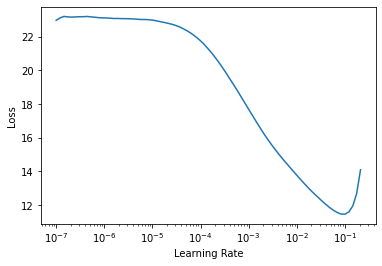

In [25]:
learn.lr_find()

In [26]:
learn.fit_one_cycle(18, 1e-3)

epoch,train_loss,valid_loss,time
0,4.021975,3.401442,01:06
1,2.442683,2.355867,01:06
2,2.028759,2.241201,01:06
3,1.848112,1.860008,01:06
4,1.691508,1.748784,01:06
5,1.610980,1.635844,01:06
6,1.541000,1.650398,01:06
7,1.490756,1.507142,01:06
8,1.464202,1.469356,01:06
9,1.430215,1.415941,01:06


In [27]:
p,t = learn.get_preds()

In [28]:
len(p), p[0].shape

(5, torch.Size([100, 1, 64, 64]))

In [29]:
def show_res(t, idx, argmax=False):
    if argmax:
        im_seq = ImageSeq.create([t[i][idx].argmax(0).unsqueeze(0) for i in range(5)], TensorMask)
    else:
        im_seq = ImageSeq.create([t[i][idx] for i in range(5)])
    im_seq.show(figsize=(8,4));

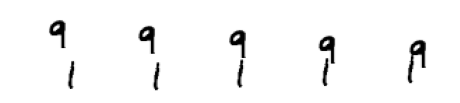

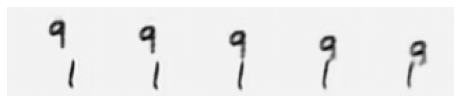

In [30]:
k = random.randint(0,99)
show_res(t,k)
show_res(p,k, False)

In [31]:
p_s = torch.stack(p, dim=1)

In [32]:
p_s.min(), p_s.max()

(tensor(-1.0059), tensor(5.1347))

In [33]:
learn.save('phydnet')

Path('models/phydnet.pth')